In [1]:
%run tools.ipynb

### play with NN model

In [13]:
# --- import necessary libraries

from xenonpy.model import Layer1d
from torch.nn import Sequential
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px

In [64]:
# --- build nn regression model

def Net(n_feature, n_hidden1, n_hidden2, n_hidden3, n_output):
    return Sequential(
        Layer1d(n_in=n_feature, n_out=n_hidden1), 
        Layer1d(n_in=n_hidden1, n_out=n_hidden2),
        Layer1d(n_in=n_hidden2, n_out=n_hidden3),
        Layer1d(n_in=n_hidden3, n_out=n_output, act_func=None, batch_nor=None)
    ) 

nn_model = Net(
    n_feature=290,
    n_hidden1=200,
    n_hidden2=100,
    n_hidden3=30,
    n_output=1)

In [4]:
# --- check model

nn_model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=200, bias=True)
    (batch_nor): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (1): Layer1d(
    (layer): Linear(in_features=200, out_features=100, bias=True)
    (batch_nor): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (2): Layer1d(
    (layer): Linear(in_features=100, out_features=30, bias=True)
    (batch_nor): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (3): Layer1d(
    (layer): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [5]:
from xenonpy.model.training import Trainer, SGD, MSELoss
from xenonpy.model.utils import regression_metrics
from xenonpy.model.training.extension import TensorConverter, Validator

In [26]:
x = np.linspace(-1, 1, 100)
y = np.power(x_val, 2) + 0.2 * np.random.rand(x_val.size)

x_val = np.linspace(-1, 1, 100)
y_val = np.power(x_val, 2) + 0.2 * np.random.rand(x_val.size)

In [16]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [33]:
torch.manual_seed(1)

trainer = Trainer(
    model=Net(n_feature=1, n_hidden=10, n_output=1),
    optimizer=SGD(),
    loss_func=MSELoss(),
    epochs=100
)

trainer.extend(
    TensorConverter(),
    Validator(
        x_val=x_val,
        y_val=y_val,
        metrics_func=regression_metrics),
)
trainer

Trainer(cuda=None, epochs=100, loss_func=MSELoss(), lr_scheduler=None,
        model=Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
),
        model_modifier=None,
        optimizer=SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
),
        verbose=True)

In [34]:
trainer.fit(x, y)

100%|██████████| 100/100 [00:00<00:00, 643.89it/s]


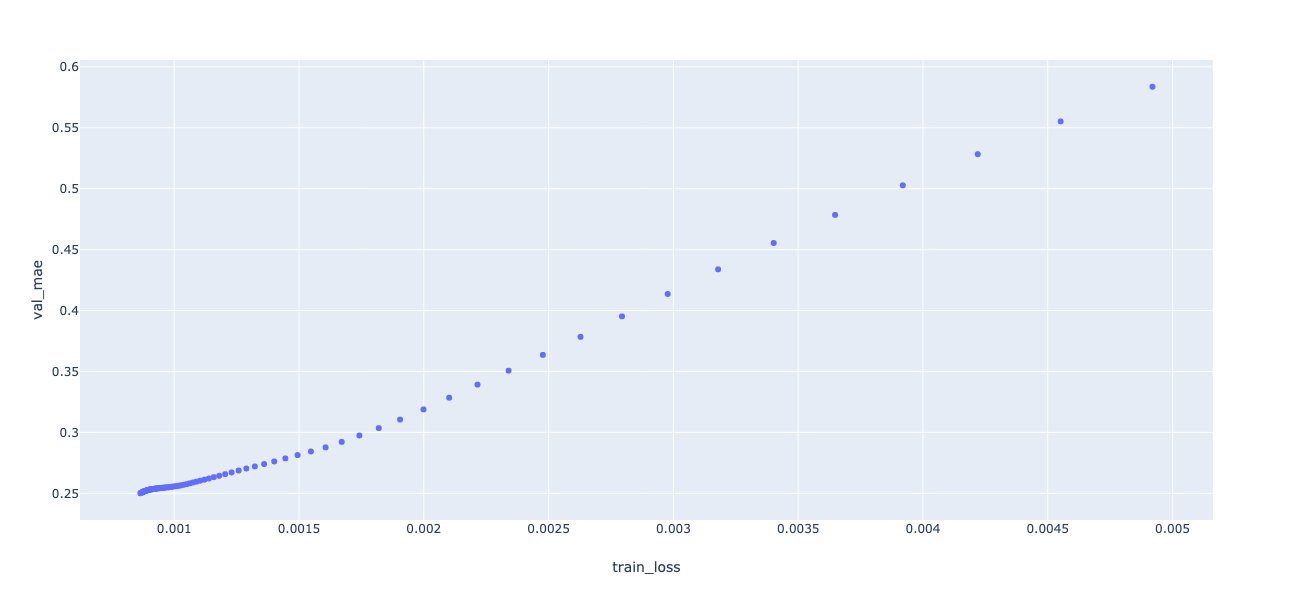

In [38]:
fig = px.scatter(trainer.step_info, x='train_loss', y='val_mae')
fig.show()


# Model training

In [44]:
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

In [45]:
data = preset.mp_inorganic
data = data.sample(3000)
data.head(5)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,has_bandstructure,is_hubbard,is_ordered,n_elemets,nsites,oxide_type,point_group,pretty_formula,space_group,space_group_number,total_magnetization,volume
mp-1217893,0.0000,"{'Ta': 1.0, 'Nb': 1.0, 'Al': 6.0}",5.658405,0.003544,NaN,"[Al, Nb, Ta]",-5.923998,-0.366836,False,False,True,3,8,None,4/mmm,TaNbAl6,P4/mmm,123,0.000005,127.875084
mp-1213787,0.5133,"{'Cl': 4.0, 'O': 8.0, 'F': 8.0}",2.111373,0.105880,NaN,"[Cl, F, O]",-3.242963,-0.730678,False,False,True,3,20,oxide,2/m,Cl(OF)2,C2/m,12,1.000000,331.730170
mp-554272,0.8347,"{'Cu': 24.0, 'Sb': 8.0, 'S': 24.0}",5.027104,0.028412,5.531261,"[Cu, S, Sb]",-4.304966,-0.473695,True,False,True,3,56,None,2/m,Cu3SbS3,P2_1/c,14,0.001174,1079.722376
mp-1204058,0.3799,"{'Zn': 3.0, 'Cu': 2.0, 'H': 14.0, 'S': 2.0, 'O...",3.075420,0.025112,NaN,"[Cu, H, O, S, Zn]",-5.139538,-1.536961,False,False,True,5,39,hydroxide,-1,Zn3Cu2H14(SO9)2,P-1,2,2.000000,372.314563
mp-1079878,0.6902,"{'Te': 1.0, 'N': 2.0, 'Cl': 6.0}",2.111664,1.010499,NaN,"[Cl, N, Te]",-2.554798,0.397476,False,False,True,3,9,None,m-3m,Te(NCl3)2,Fm-3m,225,6.000001,289.642999


In [46]:
desc = Compositions(featurizers='classic').transform(data['composition']).astype('float32')
prop = data['volume'].to_frame().astype('float32')

desc.head(5)
prop.head(5)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-1217893,24.000000,144.125000,242.875000,10.212500,54.467934,3394.125000,103.250000,643.375000,132.500000,131.125000,...,1.0,3.0,0.140000,54.00000,184.0,225.0,236.0,316.500000,3400.0,6.800000
mp-1213787,10.200000,141.560776,174.800003,16.180000,21.088961,117.800003,49.381992,30.180000,69.599998,70.599998,...,2.0,2.0,0.740458,0.00890,147.0,146.0,171.0,336.399994,206.0,0.557000
mp-554272,26.571428,132.000000,219.857147,12.314285,58.368286,1797.353149,69.300003,245.142853,121.428574,112.142860,...,1.0,3.0,0.205000,0.20500,180.0,189.0,215.0,349.500000,3420.0,2.900000
mp-1204058,8.666667,119.528862,173.384613,13.389744,17.678102,322.127899,68.474457,51.993332,63.128204,60.666668,...,1.0,1.0,0.385000,0.02658,110.0,120.0,162.0,276.299988,317.5,0.666793
mp-1079878,18.666666,136.458099,204.000000,18.588888,40.923779,316.600006,20.703308,122.777779,99.111115,96.888885,...,2.0,2.0,0.201000,0.00890,155.0,166.0,193.0,366.000000,206.0,1.100000


,volume
mp-1217893,127.875084
mp-1213787,331.730164
mp-554272,1079.722412
mp-1204058,372.314575
mp-1079878,289.643005


In [47]:
sp = Splitter(3000)
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [48]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(2400, 290)

(2400, 1)

(600, 290)

(600, 1)

In [65]:
trainer = Trainer(
    model=nn_model,
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
    lr_scheduler=ExponentialLR(gamma=0.8),
    epochs=1000,
)

In [66]:
trainer.extend(
    TensorConverter(),
    Validator(x_test, y_test,
        metrics_func=regression_metrics),
)

In [67]:
trainer.fit(x_train=desc, y_train=prop)

100%|██████████| 1000/1000 [00:24<00:00, 40.99it/s]


# Model testing

In [68]:
y_pred = trainer.predict(x_test)

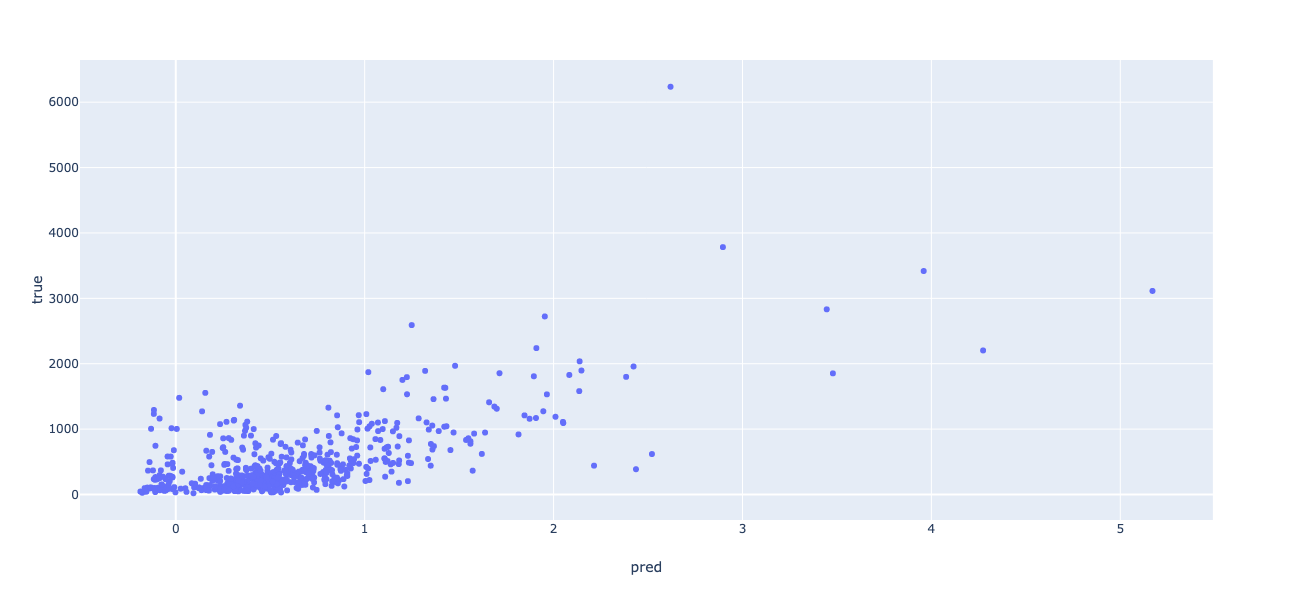

In [69]:
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_test.flatten()}), x='pred', y='true')
fig.show()

In [70]:
fig = px.line(trainer.step_info, x='i_epoch', y='train_loss')
fig.show()


### model building with random hyper parameters

In [25]:
# --- import necessary libraries

from xenonpy.model.nn import Generator1d
from xenonpy.model.nn import wrap

# 3rd packages
from torch.nn import ReLU, Tanh
from math import ceil

In [26]:
# parameter scheduler
def scheduler(i, paras):
    n_out = max(ceil(paras['n_out'] * uniform(0.3, 0.8)),5)
    return dict(paras, n_out=n_out)

# model generator
generator = Generator1d(290, 1,  # num of input an output neuron
                n_neuron=[ceil(uniform(0.8, 1.0) * 150) for n in range(5)],  # variety of neuron num in each layer
                act_func=(ReLU(),),   # variety of activation function in each layer
                drop_out=(0.1,),  # variety of dropout rate in each layer
                batch_normalize=(wrap.L1.batch_norm(),)
               )

In [30]:
# --- generate models

models = generator(4, n_models=1, replace=True, scheduler=scheduler)

In [31]:
# --- check the model generator

models

<generator object Generator1d.__call__ at 0x1a48e97ca8>

In [32]:
model = list(models)[0]
model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=125, bias=True)
    (batch_nor): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=125, out_features=69, bias=True)
    (batch_nor): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=69, out_features=38, bias=True)
    (batch_nor): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=38, out_features=16, bias=True)
    (batch_nor): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Linear(in_features=16, out_features=1, bi